In [13]:
# notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# external imports
import numpy as np
import sympy as sp

# internal imports
from warm_start_hmpc.controller import HybridModelPredictiveController
from mld_dynamics_complementarity import CartPoleWithWalls
from warm_start_hmpc.mcais import mcais, solve_dare

In [18]:
# cart-pole system with MLD dynamics
cp = CartPoleWithWalls()

# hybrid controller
T = 20

# weight matrices
C = np.diag(np.reciprocal(cp.x_max)) * cp.h
D = np.array([[np.reciprocal(cp.fc_max)]]).T * cp.h

# LQR cost to go
P, K = solve_dare(cp.mld.A, cp.mld.B[:,:1], C.dot(C), D.dot(D))
C_T = np.linalg.cholesky(P).T
D = np.hstack((D, np.zeros((1, cp.mld.nu-1))))
objective = [C, D, C_T]

# mcais terminal set
A_cl = cp.mld.A + cp.mld.B[:,:1].dot(K)
lhs_cl = cp.mld.F + cp.mld.G[:,:1].dot(K)
terminal_set = mcais(A_cl, lhs_cl, cp.mld.h, verbose=True)

controller = HybridModelPredictiveController(
    cp.mld,
    T,
    objective,
    terminal_set
)

# initial push towards the right wall
x0 = np.array([0., 0., 1., 0.])

Time horizon: 15. Convergence index: 0.000000. Number of facets: 96.
Maximal constraint-admissible invariant set found. Removing redundant facets ... minimal facets are 56.


## Open-loop solution

In [ ]:
# solve in open loop
solution, leaves = controller.feedforward(
    x0,
    draw_label='Cart pole with walls'
)

In [ ]:
x_gurobi, obj_gurobi = controller.feedforward_gurobi(x0)

In [ ]:
from visualizer import vis, animate
vis.jupyter_cell()

In [ ]:
animate(solution.variables['x'], cp.h)
# animate(x_gurobi, h_nom)

## Solve in closed loop

In [16]:
from visualizer import vis, visualize
vis.jupyter_cell()

In [19]:
# set up simulation
T_sim = T
x_true = [x0]
x_predicted = []
u_sim = []
e_sim = []
V_sim = []
warm_start = None

for t in range(T_sim):
    print('Time step %d.'%t)#, end='\r')
    
    # solve miqp
    solution, leaves = controller.feedforward(
        cp.project_in_feasible_set(x_true[-1]),
        warm_start=warm_start,
        printing_period=20.
    )
    
    # reorganize solution
    uc0 = solution.variables['uc'][0]
    ub0 = solution.variables['ub'][0]
    u0 = np.concatenate((uc0, ub0))
    x1 = cp.simulate(x_true[-1], uc0[0:1], cp.h)[0][-1]
    e0 = x1 - cp.mld.A.dot(x_true[-1]) - cp.mld.B.dot(u0)
    print('predicted state:', solution.variables['x'][1])
    print('true state:', x1)
    print('modeling error:', e0)
    visualize(x1)
    
    # generate warm start
    warm_start = controller.construct_warm_start(
        leaves,
        cp.project_in_feasible_set(x_true[-1]),
        uc0,
        ub0,
        e0
    )
    
    # retrieve closed-loop trajectory
    x_predicted.append(solution.variables['x'][1])
    x_true.append(x1)
    u_sim.append(uc0)
    e_sim.append(e0)
    V_sim.append(solution.objective)

Time step 0.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.04            1               2.600e-02       inf             
 New incumbent   2.59            80              4.065e-02       4.079e-02       
 Solution found  2.62            81              4.079e-02       4.079e-02       

Explored 81 nodes in 2.620 seconds: optimal solution found with cost 4.079e-02.
predicted state: [ 0.04640387 -0.00359613  0.92807749 -0.07192251]
true state: [ 0.04816208 -0.00184182  0.92777733 -0.07252296]
modeling error: [ 0.0017582   0.0017543  -0.00030017 -0.00060045]
Time step 1.
Loaded warm start with 40 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.25            8               3.892e

 New incumbent   0.47            16              2.243e-02       2.249e-02       
 Solution found  0.50            17              2.249e-02       2.249e-02       

Explored 17 nodes in 0.500 seconds: optimal solution found with cost 2.249e-02.
predicted state: [ 0.32471774 -0.08618458  0.05010267  0.44648003]
true state: [ 0.32586623 -0.08359233  0.05818328  0.46105784]
modeling error: [0.00114849 0.00259225 0.00808061 0.01457781]
Time step 13.
Loaded warm start with 53 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.47            15              1.963e-02       1.963e-02       
 Solution found  0.47            15              1.963e-02       1.963e-02       

Explored 15 nodes in 0.466 seconds: optimal solution found with cost 1.963e-02.
predicted state: [ 0.32619905 -0.06520559  0.00665644  0.36773483]
true

<IPython.core.display.Javascript object>


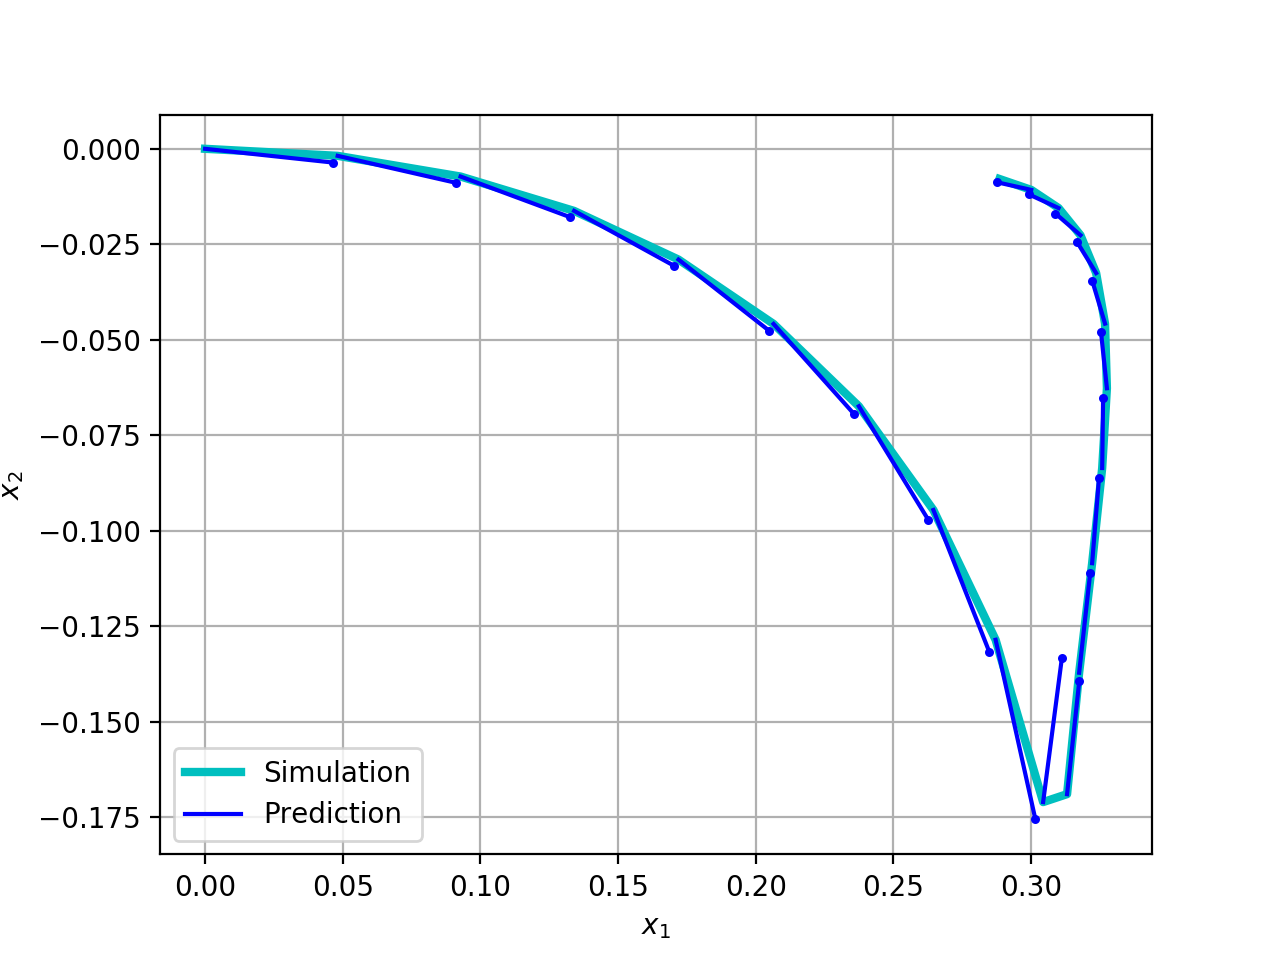

In [20]:
import matplotlib.pyplot as plt

indices =  [0,1]

fig = plt.figure()

plt.plot(
    [xt[indices[0]] for xt in x_true],
    [xt[indices[1]] for xt in x_true],
    color='c',
    label='Simulation',
    linewidth=3
)

for t in range(T_sim):
    label = 'Prediction'
    if t > 0:
        label=None
    plt.plot(
        [x_true[t][indices[0]], x_predicted[t][indices[0]]],
        [x_true[t][indices[1]], x_predicted[t][indices[1]]],
        c='b',
        label=label
    )
    plt.scatter(
        [x_predicted[t][indices[0]]],
        [x_predicted[t][indices[1]]],
        c='b',
        marker='o',
        s=5,
        zorder=3
    )
# plt.plot([0.], [0.], c='b', marker='o', markersize=5, label='Prediction')

#     marker='o',
#     markersize=12,
#     markerfacecolor='w',
    

#     arrow = plt.arrow(
#         x_true[t][0],
#         x_true[t][1],
#         x_predicted[t][0]-x_true[t][0],
#         x_predicted[t][1]-x_true[t][1],
#         length_includes_head=True,
#         fc='k',
#         ec='k'
#     )
    
        
# for t, xt in enumerate(x_true):
#     plt.text(
#         xt[0],
#         xt[1],
#         r'$%d$'%t,
#         horizontalalignment='center',
#         verticalalignment='center',
#         fontsize=7
#     )
plt.xlabel(r'$x_%d$'%(indices[0]+1))
plt.ylabel(r'$x_%d$'%(indices[1]+1))
# ax.set_zlabel(r'Solved QPs')
plt.legend()
plt.grid(True)
plt.show()

## Animation

In [ ]:
from visualizer import vis, animate
vis.jupyter_cell()

In [ ]:
x0 = np.array([0, 0, 1, 0])
u0 = np.zeros(1)
dt = 5
x_sim, h = cp.simulate(x0, u0, dt)
animate(x_sim, h)